In [1]:
import os
import gzip as gz
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True, precision=2)

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

from pyspark.sql import functions as F

from operator import add

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

24/03/06 08:55:01 WARN Utils: Your hostname, AirBook-15.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
24/03/06 08:55:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/06 08:55:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/03/06 08:55:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Data

Read known data fields with a schema

In [4]:
# loaded from auto-detect schema
schema = StructType([
    StructField('y', IntegerType(), True), 
    StructField('x1', IntegerType(), True), 
    StructField('x2', IntegerType(), True), 
    StructField('x3', IntegerType(), True), 
    StructField('x4', IntegerType(), True), 
    StructField('x5', IntegerType(), True), 
    StructField('x6', IntegerType(), True), 
    StructField('x7', IntegerType(), True), 
    StructField('x8', IntegerType(), True), 
    StructField('x9', IntegerType(), True), 
    StructField('x10', IntegerType(), True), 
    StructField('x11', IntegerType(), True), 
    StructField('x12', IntegerType(), True), 
    StructField('x13', IntegerType(), True), 
])

In [5]:
# note the input is a folder!

df_data = spark.read.options(delimiter="\t").csv("./day0", schema=schema)
df_data = df_data.fillna(-1)

df_data.show(5)

+---+---+----+---+---+---+---+---+---+---+---+---+----+---+
|  y| x1|  x2| x3| x4| x5| x6| x7| x8| x9|x10|x11| x12|x13|
+---+---+----+---+---+---+---+---+---+---+---+---+----+---+
|  0|  1|  56|  2|  1| -1|  3|  0| 90|  6|  1| -1|   2|  1|
|  0|  6|1373| -1| -1| -1|  0|  0|  4|  2|  0| -1|9810| -1|
|  0| -1|   6|  2|  2|  8|  4|  0| 15|  2|  1|  2|  34|  2|
|  0| 16| 611| 16| 49| 14|  0|  0|  0| 16|  0|  1|1827| 16|
|  0| 86| 552|  0| 55|  2|  0|  0|547|  5|  0|  1|7545|  6|
+---+---+----+---+---+---+---+---+---+---+---+---+----+---+
only showing top 5 rows



#### Let's scale one column

In [6]:
x12 = (
    df_data
    .limit(10000)
    .agg(
        F.mean("x12").alias("m"),
        F.stddev("x12").alias("s"),
    )
    .collect()
)

In [7]:
m = x12[0]['m']
s = x12[0]['s']

m, s

(21865.0745, 71829.92320349441)

In [8]:
df_data = df_data.withColumn("x12", (F.col("x12") - m) / s)

df_data.show(5)

+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
|  y| x1|  x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|                 x12|x13|
+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
|  0|  1|  56|  2|  1| -1|  3|  0| 90|  6|  1| -1| -0.3043727951380629|  1|
|  0|  6|1373| -1| -1| -1|  0|  0|  4|  2|  0| -1|-0.16782802991237972| -1|
|  0| -1|   6|  2|  2|  8|  4|  0| 15|  2|  1|  2| -0.3039272983510297|  2|
|  0| 16| 611| 16| 49| 14|  0|  0|  0| 16|  0|  1| -0.2789655565025744| 16|
|  0| 86| 552|  0| 55|  2|  0|  0|547|  5|  0|  1|-0.19936084936957513|  6|
+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
only showing top 5 rows



#### Scale outputs `y` for balanced representation

In [9]:
df_data.groupby("y").agg(F.count("*")).show()

+---+--------+
|  y|count(1)|
+---+--------+
|  1|   72153|
|  0| 2327847|
+---+--------+



In [11]:
2327847/72153

32.262650201654814

In [12]:
df_data = df_data.withColumn("y", F.col("y") * 32)

24/03/06 01:35:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [13]:
df_data.filter("y > 0").show(5)

+---+---+----+---+---+---+---+---+----+---+---+---+--------------------+---+
|  y| x1|  x2| x3| x4| x5| x6| x7|  x8| x9|x10|x11|                 x12|x13|
+---+---+----+---+---+---+---+---+----+---+---+---+--------------------+---+
| 32|  3| 149|  6|  5| 28|  1|  0|1031|  8|  1|  5|-0.30402475077319324|  5|
| 32| 15| 852|  5| -1| 32|  0|  0|  23|  8|  0|  4|-0.24669488299185519|  5|
| 32| -1|  32| -1| -1| -1|  0|  0|   0|  3|  0| -1| -0.2844785792421105| -1|
| 32| 68| 541|  2| -1| -1|  0|  0|  80|  0|  0| -1| -0.3042892644904942|  2|
| 32|  2|2220|  3| -1| 11|  0|  0|   1|  4|  0|  2|-0.08408855572472836|  3|
+---+---+----+---+---+---+---+---+----+---+---+---+--------------------+---+
only showing top 5 rows



## Setup

In [14]:
d = 13  # number of features in X
num_out = 1  # number of features in Y

l = 100  # number of hidden neurons

In [15]:
batch_N = 5000
batch_l = 65

In [16]:
W = np.random.randn(d, l-1)
W = np.hstack([ W, np.zeros((W.shape[0], 1)) ])  # zero-neuron that adds bias

# bias constant
b = np.zeros((1, l))
b[0, -1] = 1

In [17]:
W.shape, b.shape

((13, 100), (1, 100))

Broadcast ELM random weights to Spark

In [18]:
# condition check removes the last empty batch when W divides by batch size equally
split_idx = [batch_l*(i+1) for i in range(l // batch_l) if batch_l*(i+1) < l]
l_blocks = len(split_idx) + 1

# split W and bias at once
Wb = [(wb, bias_b) for wb,bias_b in zip(
    np.array_split(W, split_idx, axis=1),
    np.array_split(b, split_idx, axis=1)
)]

In [19]:
spWb = sc.parallelize(enumerate(Wb))
spW2 = sc.broadcast(spWb.cartesian(spWb).collect())

# for H'Y computation
spW0 = sc.broadcast(W)
spb0 = sc.broadcast(b)

## Process a bunch of Numpy arrays into chunks of HH arrays

## _PYSPARK_

In [20]:
def compute(buffer):    
    data0 = pd.DataFrame(buffer).fillna(-1).to_numpy().astype(int)
    y0 = data0[:, :num_out]  # first `num_out` data columns belong to Y, rest to X
    x0 = data0[:, num_out:]

    for w in spW2.value:
        i, (w1, b1) = w[0]
        j, (w2, b2) = w[1]

        if j < i:
            yield ((i, j), (0, 0))  # format is  [ (HtH block coordinates), (HtH, HtY) ]
        else:            
            if i == 0 and j == 0:
                # report HtY once per batch
                yield (
                    (i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), np.tanh(x0@spW0.value + spb0.value).T @ y0))
            else:
                # Qb = (f(X0@Wb1) + bb1).T @ (f(X0@Wb2) + bb2)
                yield ((i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), 0))

In [21]:
def process_partition(data):
    os.environ['OMP_NUM_THREADS'] = '1'  # Set OMP threads to 1

    buf = []
    
    for d in data:
        buf.append(d)
        if len(buf) >= batch_N:
            yield from compute(buf)
            buf = []
            
    if len(buf) > 0:
        yield from compute(buf)

Define computational graph here - nothing runs yet

In [22]:
spBlocks = (
    df_data.rdd.map(np.array)
    .mapPartitions(process_partition)
    .foldByKey((0, 0), lambda a,b: (a[0]+b[0], a[1]+b[1]))
)

## Request data to trigger computations

In [23]:
%%time

# prepare empty block matrix storage
HtH_blocks = [[ [] for _ in range(l_blocks)  ] for _ in range(l_blocks)]
HtY = 0

# gather data into block matrix
for (i, j), (HtH_part, HtY_part) in spBlocks.collect():
    HtH_blocks[i][j] = HtH_part
    HtY += HtY_part

# fill missing triangular part
for i in range(l_blocks):
    for j in range(l_blocks):
        if j > i:
            HtH_blocks[j][i] = HtH_blocks[i][j].T

HtH = np.block(HtH_blocks)
HtH.shape, HtY.shape

CPU times: user 7.92 ms, sys: 3.57 ms, total: 11.5 ms
Wall time: 11.1 s


((100, 100), (100, 1))

## Compute ELM output weights

In [24]:
# add L2-regularization to the diagonal to HtH
B = np.linalg.solve(HtH + 1e+3 * np.eye(HtH.shape[0]), HtY)
B.shape

(100, 1)

## Test with another file

In [25]:
df_test = spark.read.options(delimiter="\t").csv("day0_1m_2.txt.gz", schema=schema)
df_test = df_test.fillna(-1)

df_test.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|  y| x1| x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|  x12|x13|
+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|  0| 30|132| 10| 60|  2|  0|  0|  3| 24|  0|  1| 5222| 21|
|  0|  1|232|  7| 44|  4|  0|  0|  0|  8|  0|  2| 2584|  7|
|  0|  1|  6|  1| -1| -1|  0|  0|  3|  8|  0| -1|   11|  1|
|  0| -1| 76| -1| 10|  1|  0|  0| -1|  0|  0|  1|24315| -1|
|  0|  3|  9|  1| -1| -1|  0|  0|322|  5|  0| -1| 1458|  4|
+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
only showing top 5 rows



In [26]:
df_test = (
    df_test
    .withColumn("x12", (F.col("x12") - m) / s)
)

In [27]:
df_test.show(3)

+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
|  y| x1| x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|                 x12|x13|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
|  0| 30|132| 10| 60|  2|  0|  0|  3| 24|  0|  1|-0.23170113175326823| 21|
|  0|  1|232|  7| 44|  4|  0|  0|  0|  8|  0|  2| -0.2684267731343197|  7|
|  0|  1|  6|  1| -1| -1|  0|  0|  3|  8|  0| -1|-0.30424749916670984|  1|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
only showing top 3 rows



In [28]:
X_test = df_test.toPandas().iloc[:, 1:].to_numpy()
Y_test = df_test.toPandas().iloc[:, 0].to_numpy()

In [29]:
Y_score = np.tanh(X_test @ W + b) @ B

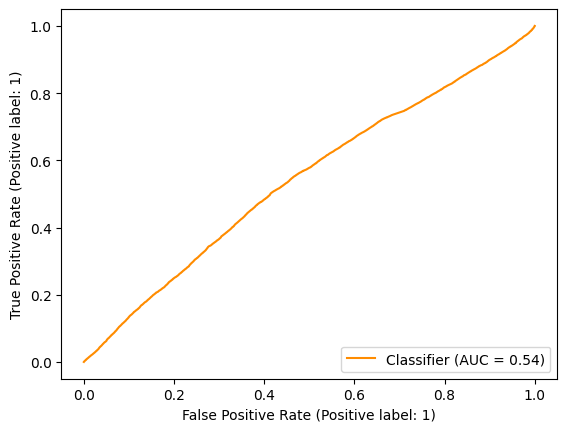

In [30]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    Y_test,
    Y_score,
    color="darkorange",
)